## Prepping Data
- Query in IPUMS 
- Download R script, data extract
- Modify R script to add `write.csv(data, file = "census.csv")`

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import time

In [2]:
data = pd.read_csv('./data/census.csv').drop(columns='Unnamed: 0')

In [3]:
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,SEX,AGE,MARST,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,FTOTINC
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,1,73,3,2,200,2,25,3,30,10000.0
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,2,31,6,1,100,10,101,1,10,38500.0
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,1,41,1,1,100,6,64,1,10,90700.0
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,2,48,1,1,100,6,63,3,30,90700.0
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,1,16,6,1,100,4,40,3,30,90700.0


For neighborhood type category, need to calculate tract-weighted average density for each PUMA

In [4]:
puma_total_population = data['PUMA'].value_counts()
puma_addresses = data.groupby('PUMA')['SERIAL'].nunique()
puma_density = puma_total_population/puma_addresses
data['PUMA_TRACT_DENSITY'] = data['PUMA'].map(puma_density)

In [5]:
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,SEX,AGE,MARST,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,FTOTINC,PUMA_TRACT_DENSITY
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,1,73,3,2,200,2,25,3,30,10000.0,2.263719
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,2,31,6,1,100,10,101,1,10,38500.0,2.206161
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,1,41,1,1,100,6,64,1,10,90700.0,2.232037
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,2,48,1,1,100,6,63,3,30,90700.0,2.232037
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,1,16,6,1,100,4,40,3,30,90700.0,2.232037


Perform one-hot encoding on categorical data (sex, race/ethnicity, neighborhood type, marital status, education, employment status), extract relevant columns for clustering

In [6]:
categorical_vars = ['SEX', 'RACE', 'MARST', 'EDUC', 'EMPSTAT']
data = pd.get_dummies(data, columns=categorical_vars)

In [7]:
data.columns

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'PUMA', 'GQ', 'PERNUM',
       'PERWT', 'AGE', 'RACED', 'EDUCD', 'EMPSTATD', 'FTOTINC',
       'PUMA_TRACT_DENSITY', 'SEX_1', 'SEX_2', 'RACE_1', 'RACE_2', 'RACE_3',
       'RACE_4', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8', 'RACE_9', 'MARST_1',
       'MARST_2', 'MARST_3', 'MARST_4', 'MARST_5', 'MARST_6', 'EDUC_0',
       'EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4', 'EDUC_5', 'EDUC_6', 'EDUC_7',
       'EDUC_8', 'EDUC_10', 'EDUC_11', 'EMPSTAT_0', 'EMPSTAT_1', 'EMPSTAT_2',
       'EMPSTAT_3'],
      dtype='object')

In [8]:
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,PUMA,GQ,PERNUM,PERWT,AGE,...,EDUC_5,EDUC_6,EDUC_7,EDUC_8,EDUC_10,EDUC_11,EMPSTAT_0,EMPSTAT_1,EMPSTAT_2,EMPSTAT_3
0,2017,201701,1.0,2.017000e+12,206,2500,1,1,206,73,...,0,0,0,0,0,0,0,0,0,1
1,2017,201701,2.0,2.017000e+12,45,1800,1,1,45,31,...,0,0,0,0,1,0,0,1,0,0
2,2017,201701,3.0,2.017000e+12,136,2400,1,1,136,41,...,0,1,0,0,0,0,0,1,0,0
3,2017,201701,3.0,2.017000e+12,136,2400,1,2,121,48,...,0,1,0,0,0,0,0,0,0,1
4,2017,201701,3.0,2.017000e+12,136,2400,1,3,111,16,...,0,0,0,0,0,0,0,0,0,1


Extract only relevant columns and normalize

In [9]:
relevant_data = data.filter(regex='AGE|RACE_|SEX|PUMA_TRACT_DENSITY|MARST|EDUC_|FTOTINC|EMPSTAT_')

In [10]:
relevant_data.columns

Index(['AGE', 'FTOTINC', 'PUMA_TRACT_DENSITY', 'SEX_1', 'SEX_2', 'RACE_1',
       'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'RACE_7', 'RACE_8',
       'RACE_9', 'MARST_1', 'MARST_2', 'MARST_3', 'MARST_4', 'MARST_5',
       'MARST_6', 'EDUC_0', 'EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4', 'EDUC_5',
       'EDUC_6', 'EDUC_7', 'EDUC_8', 'EDUC_10', 'EDUC_11', 'EMPSTAT_0',
       'EMPSTAT_1', 'EMPSTAT_2', 'EMPSTAT_3'],
      dtype='object')

In [11]:
scaler = StandardScaler()
scaler.fit(relevant_data)
scaled_data = scaler.transform(relevant_data)

C:\Users\atran39\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\atran39\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Use DSCAN to estimate # of clusters

In [12]:
runs = 1
num_clusters_list = []
sample_ratio = .1
dbscan_min_samples = 500

time_flag = True # use this to measure the time to run DBSCAN for each sample run, for me it was ~4500s per iteration using 

if time_flag:
    t0 = time.time()

for _ in range(runs):
    num_samples = int(sample_ratio * scaled_data.shape[0])
    samples = scaled_data[np.random.choice(scaled_data.shape[0], num_samples, replace=True)]
    db = DBSCAN(min_samples=dbscan_min_samples).fit(samples)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters_list.append(n_clusters_)
    
    if time_flag:
        t1 = time.time()
        delta = t1 - t0
        t0 = t1
        print(delta)
        
print('num_clusters_list:', num_clusters_list)
optimal_n = int(np.rint(np.mean(num_clusters_list)))

10803.375027656555
num_clusters_list: [53]


In [13]:
optimal_n

53

In [14]:
kmeans = KMeans(n_clusters=optimal_n).fit(scaled_data)
# kmeans.cluster_centers_

In [15]:
labels, counts = np.unique(kmeans.labels_, return_counts=True)

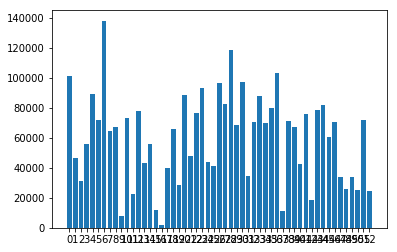

In [16]:
plt.bar(range(len(counts)), counts)
plt.xticks(range(len(labels)), labels)
plt.show()

In [23]:
num_clusters = optimal_n
largest_clusters_indexes = np.argsort(-counts[:num_clusters])
largest_cluster_centriods = kmeans.cluster_centers_[largest_clusters_indexes]
cluster_centriods_rescaled = pd.DataFrame(data=scaler.inverse_transform(largest_cluster_centriods), columns=relevant_data.columns)
cluster_centriods_rescaled['total_pop'] = counts[largest_clusters_indexes]
cluster_centriods_rescaled

,AGE,FTOTINC,PUMA_TRACT_DENSITY,SEX_1,SEX_2,RACE_1,RACE_2,RACE_3,RACE_4,RACE_5,...,EDUC_6,EDUC_7,EDUC_8,EDUC_10,EDUC_11,EMPSTAT_0,EMPSTAT_1,EMPSTAT_2,EMPSTAT_3,total_pop
0,75.971304,9.473541e+05,2.276695,2.148028e-01,7.851972e-01,9.000333e-01,9.756327e-02,-4.074865e-14,3.295107e-14,2.927780e-15,...,5.337638e-01,1.284386e-01,4.892280e-02,1.176666e-01,7.644640e-02,1.447849e-05,1.596398e-01,-2.409878e-14,8.403457e-01,138136
1,49.521680,9.554349e+04,2.296382,1.000000e+00,-5.961898e-14,1.000000e+00,1.926653e-13,-3.195534e-14,3.085900e-14,2.817191e-15,...,9.785944e-01,1.327410e-13,9.713064e-14,-1.987854e-13,-2.803313e-15,1.686810e-05,9.999831e-01,-2.359224e-14,2.318146e-13,118567
2,62.793628,6.997310e+04,2.292051,5.411227e-13,1.000000e+00,1.000000e+00,1.658118e-13,-2.284457e-14,2.869233e-14,2.702699e-15,...,9.311545e-01,2.771394e-14,7.073508e-14,-1.914302e-13,-1.298683e-13,1.669220e-13,8.846812e-13,-2.306488e-14,1.000000e+00,103391
3,7.698209,1.896264e+05,2.324818,1.000000e+00,-5.928591e-14,8.368178e-01,1.174360e-01,-2.148455e-14,2.836793e-14,2.685352e-15,...,-5.904721e-13,1.201816e-14,6.680767e-14,-1.903200e-13,-1.392497e-13,9.945294e-01,3.400656e-03,-2.298509e-14,2.069965e-03,101451
4,7.704298,1.787965e+05,2.324596,4.229395e-13,1.000000e+00,8.302034e-01,1.222979e-01,-1.837766e-14,2.763068e-14,2.646321e-15,...,-5.815903e-13,-2.377265e-14,5.780099e-14,-1.878220e-13,-1.369321e-13,9.942130e-01,2.209956e-03,-2.280467e-14,3.577045e-03,97287
5,31.642433,2.702726e+05,2.510373,5.012663e-01,4.987337e-01,1.266209e-12,1.504491e-13,-1.763520e-14,2.745373e-14,2.636780e-15,...,3.087814e-01,1.119992e-01,4.328420e-02,6.671165e-02,2.640648e-02,2.884887e-01,4.976438e-01,-2.275957e-14,2.138676e-01,96340
6,50.950594,1.716158e+05,2.281015,3.371192e-13,1.000000e+00,9.623531e-01,3.764686e-02,-1.513546e-14,2.685872e-14,2.605555e-15,...,-5.723200e-13,-6.114553e-14,4.840572e-14,-1.851852e-13,1.000000e+00,7.108203e-14,7.459909e-01,-2.261386e-14,2.540091e-01,93288
7,47.828816,1.643792e+05,2.305231,1.000000e+00,-5.906386e-14,1.000000e+00,1.320472e-13,-1.139193e-14,2.596881e-14,2.558717e-15,...,-5.616063e-13,-1.043193e-13,3.755329e-14,1.000000e+00,-1.317280e-13,2.450817e-14,1.000000e+00,-2.239875e-14,2.211009e-13,89062
8,51.326467,7.831496e+04,2.283883,5.423322e-01,4.576678e-01,1.000000e+00,1.314088e-13,-1.117856e-14,2.591677e-14,2.555681e-15,...,5.461484e-01,9.705853e-02,3.692879e-14,2.731530e-01,6.052931e-02,2.187139e-14,1.000000e+00,-2.238487e-14,2.209899e-13,88833
9,56.360710,1.878271e+05,2.289688,1.000000e+00,-5.906386e-14,9.664614e-01,3.353859e-02,-1.041355e-14,2.573462e-14,2.546140e-15,...,-5.588308e-13,-1.110778e-13,3.470835e-14,-1.813827e-13,1.000000e+00,1.232348e-14,7.314413e-01,-2.234324e-14,2.685587e-01,88018


In [24]:
soup = BeautifulSoup(open('./data/usa_00001.xml'), 'xml')

#returns dataframe of decoded values
def cluster_decoder(cluster): # cluster needs to be df rescaled to original scale
    attributes = ['AGE','RACE','SEX','PUMA_TRACT_DENSITY','MARST','EDUC','FTOTINC','EMPSTAT']
#     categorical_vars = ['SEX', 'RACE', 'MARST', 'EDUC', 'EMPSTAT']
    decoded_df = pd.DataFrame(columns=attributes)
    pattern = r'(?P<cat>\w*)_(?P<encoding>\d+)'
    
    for attr in attributes:
        if attr in categorical_vars:
            
            encoded_cols_df = cluster.filter(like=attr)
            max_indexes = encoded_cols_df.idxmax(axis=1)
            # map maxes to english
            def map_column_to_name(column):
                regex_result = re.match(pattern, column)
                category = regex_result.group('cat')
                cur_soup = soup.dataDscr.find('var', {'ID': category})
                # translate encoded category to english
                cat_valu_encoding = regex_result.group('encoding')
                for soup_catgry in cur_soup.find_all('catgry'):
                    if soup_catgry.catValu.string == cat_valu_encoding:
                        return soup_catgry.labl.string
                
            decoded_df[attr] = max_indexes.apply(map_column_to_name)
        else:
            decoded_df[attr] = cluster[attr]
    return decoded_df
    
cluster_decoder(cluster_centriods_rescaled)

,AGE,RACE,SEX,PUMA_TRACT_DENSITY,MARST,EDUC,FTOTINC,EMPSTAT
0,75.971304,White,Female,2.276695,Widowed,None,9.473541e+05,Not in labor force
1,49.521680,White,Male,2.296382,"Married, spouse present",None,9.554349e+04,Employed
2,62.793628,White,Female,2.292051,"Married, spouse present",None,6.997310e+04,Not in labor force
3,7.698209,White,Male,2.324818,Never married/single,None,1.896264e+05,N/A
4,7.704298,White,Female,2.324596,Never married/single,None,1.787965e+05,N/A
5,31.642433,"Other race, nec",Male,2.510373,Never married/single,None,2.702726e+05,Employed
6,50.950594,White,Female,2.281015,"Married, spouse present",5+ years of college,1.716158e+05,Employed
7,47.828816,White,Male,2.305231,"Married, spouse present",4 years of college,1.643792e+05,Employed
8,51.326467,White,Male,2.283883,Divorced,None,7.831496e+04,Employed
9,56.360710,White,Male,2.289688,"Married, spouse present",5+ years of college,1.878271e+05,Employed


(array([  2561.,   1055.,   1252.,   1894.,  11394.,  14693.,  10379.,
         17197.,  29891.,  35351.,  54231., 115798., 115182., 573711.,
        717466., 328144., 225089., 150544., 123202., 100232.,  89631.,
         71580.,  53073.,  54645.,  57113.,  38219.,  33221.,  32300.,
         33649.,  11643.,  16643.,   8595.,   4501.,   7422.,   8087.,
           951.,  10859.,   2052.,   5638.,   5762.,   2479.,   2011.,
          1212.,   2899.,   2103.,      0.,      0.,   1502.,   1397.,
          1587.]),
 array([1.53392857, 1.58123526, 1.62854194, 1.67584863, 1.72315532,
        1.770462  , 1.81776869, 1.86507538, 1.91238206, 1.95968875,
        2.00699544, 2.05430212, 2.10160881, 2.1489155 , 2.19622218,
        2.24352887, 2.29083556, 2.33814224, 2.38544893, 2.43275562,
        2.4800623 , 2.52736899, 2.57467568, 2.62198236, 2.66928905,
        2.71659574, 2.76390242, 2.81120911, 2.8585158 , 2.90582248,
        2.95312917, 3.00043585, 3.04774254, 3.09504923, 3.14235591,
        

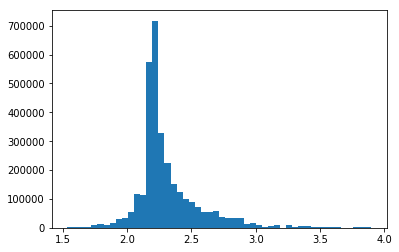

In [27]:
plt.hist(data['PUMA_TRACT_DENSITY'], bins = 50)